# Computational Methods in the Simulation and Analysis of the Cosmic Microwave Background and Cosmological Parameters

## Table of Contents

## What is the CMB?

## What is the power spectrum of the CMB?

## What does the CMB have to do with cosmological parameters?

In [91]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline

### Load different CAMB models with varying parameters

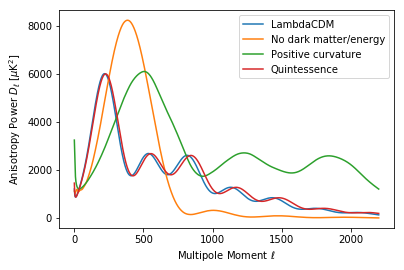

In [313]:
# Basic model
standard = np.loadtxt("camb_lcdm.dat", usecols=(0, 1), unpack=True)
plt.plot(standard[0], standard[1], label='LambdaCDM')

nodark = np.loadtxt("camb_nodark.dat", usecols=(0, 1), unpack=True)
plt.plot(nodark[0], nodark[1], label='No dark matter/energy')

kone = np.loadtxt("camb_k1.dat", usecols=(0, 1), unpack=True)
plt.plot(kone[0], kone[1], label='Positive curvature')

quint = np.loadtxt("camb_quint.dat", usecols=(0, 1), unpack=True)
plt.plot(quint[0], quint[1], label='Quintessence')

plt.ylabel('Anisotropy Power $D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('Multipole Moment $\ell$')


plt.legend()
plt.savefig('Power Spectra')
plt.show()

### Generate map from power spectrum

The power plotted above on the y-axis is $D_{\ell}$ [$\mu$K$^2$], which is traditionally what you see on power spectrum plots. However, what we need to work with is the angular power spectrum $C_\ell$ such that $D_\ell = \frac {\ell (\ell+1)} {2 \pi} C_\ell$. Below is the conversion being made below to calculate `Cpower` based on the $D_{\ell}$ plotted as `standard[1]`

In [246]:
Cpower = standard[1] * 2 * np.pi / (standard[0]*(standard[0]+1.))

Setting the resolution of the map (it needs to be very fine so that we can perform many FFTs).

In [247]:
npix = 2**10  # number of pixels
pix_size  = 0.5 # size of a pixel in arcminutes

This CMB map will be a flat-sky approximation

In [248]:
#first we create a real 2D coordinate system that's basically a NxN grid over the plot
ones = np.ones(npix)
inds = np.linspace(-0.5, 0.5, npix)
X = np.outer(ones,inds) 
Y = np.transpose(X)
R = np.sqrt(X**2. + Y**2.)

Now make a 2D CMB power spectrum by transforming into Fourier space

In [249]:
pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
multi_sf = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
multi2d = R * multi_sf # making a fourier space analogue to the real space R vector -- turn the 2d grid above into fourier space using l = 2pi*k
Cpower_full = np.zeros(int(multi2d.max())+1) 
# making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
Cpower_full[0:(Cpower.size)] = Cpower # fill in the Cls until the max of the ClTT vector
# the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
Cpower2d = Cpower_full[multi2d.astype(int)] 
   

Random realization of CMB temps

In [250]:
# now make a random realization of the CMB with the given power spectrum in real space
randomT = np.random.normal(0,1,(npix,npix))
fft_randomT = np.fft.fft2(randomT)   # take FFT since we are in Fourier space 

Multiply maps and FFT back to real space

In [251]:
fft_2d = np.sqrt(Cpower2d) * fft_randomT # we take the sqrt since the power spectrum is T^
    
# move back from l space to real space
CMB_T = np.fft.ifft2(np.fft.fftshift(fft_2d)) 
# move back to pixel space for the map
CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
# we only want to plot the real component
CMB_T = np.real(CMB_T)

        

Plot the CMB_T map

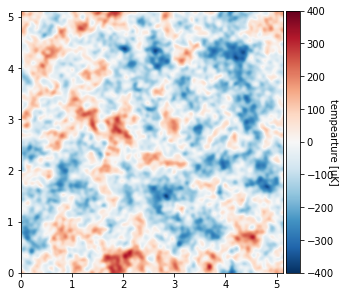

In [252]:
plt.figure(figsize=(5,5))
im = plt.imshow(CMB_T, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
im.set_clim(c_min,c_max)
im.set_extent([0,X_width,0,Y_width])

ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('tempearture [uK]', rotation=270)
    
    

Now that we've explained and demonstrated every step, let's compile into 2 functions to reuse

In [253]:
def generate_map(npix, pix_size, multi, power):
    
    Cpower = power * 2 * np.pi / (multi*(multi+1.))
    
    ones = np.ones(npix)
    inds = np.linspace(-0.5, 0.5, npix)
    X = np.outer(ones,inds) 
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    
    pix_to_rad = (pix_size/60. * np.pi/180.) 
    multi_sf = 2. * np.pi /pix_to_rad  
    multi2d = R * multi_sf 
    Cpower_full = np.zeros(int(multi2d.max())+1) 
    Cpower_full[0:(Cpower.size)] = Cpower 
    Cpower2d = Cpower_full[multi2d.astype(int)] 
    
    randomT = np.random.normal(0,1,(npix,npix))
    fft_randomT = np.fft.fft2(randomT)  
    
    fft_2d = np.sqrt(Cpower2d) * fft_randomT 
    CMB_T = np.fft.ifft2(np.fft.fftshift(fft_2d)) 
    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    CMB_T = np.real(CMB_T)
    
    return CMB_T

In [254]:
def plot_map(tmap, x_size, y_size):
    plt.figure(figsize=(x_size,y_size))
    im = plt.imshow(tmap, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    im.set_clim(-400,400)
    im.set_extent([0,((2**10)*0.5/60),0,((2**10)*0.5/60)])

    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('tempearture [uK]', rotation=270)


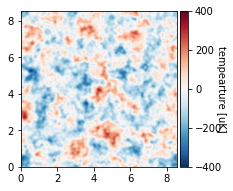

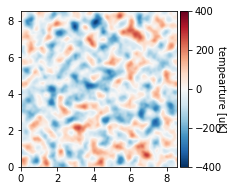

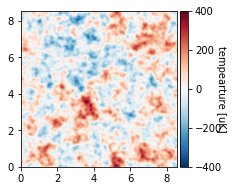

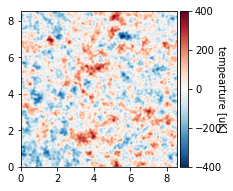

In [336]:
cmb = generate_map(npix,pix_size,standard[0],standard[1])
plot_map(cmb,3,3)

cmb_nodark = generate_map(npix,pix_size,nodark[0],nodark[1])
plot_map(cmb_nodark,3,3)

cmb_quint = generate_map(npix,pix_size,quint[0],quint[1])
plot_map(cmb_quint,3,3)

cmb_kone = generate_map(npix,pix_size,kone[0],kone[1])
plot_map(cmb_kone,3,3)

### Add beam, noise, and apodization filter

I'm choosing to only add beam, noise, and filtering convolution because this is more aligned with the things we did in this class. Adding point sources and SZ effect is simply random points and galaxy distributions from a catalogue

Beam convolution from ~1 arcminute beam of ACT and SPT
Gaussian white noise 
High pass filter (see if you can base it off last week's FFT stuff)

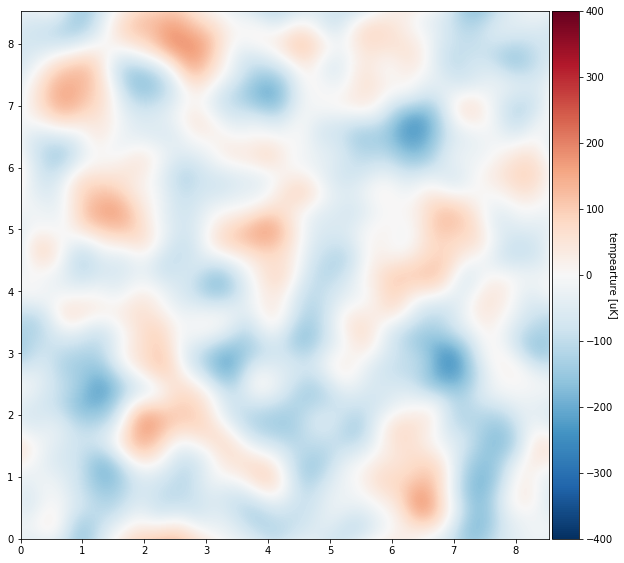

In [349]:
beam_size_fwhp = 1
npix = 2**10

def convolve(beam_size_fwhp,Map):
    "convolves a map with a Gaussian beam pattern.  NOTE: pix_size and beam_size_fwhp need to be in the same units" 
    # make a 2d gaussian 
    
    ones = np.ones(npix)
    inds = (np.arange(npix)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds) 
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
   
    beam_sigma = beam_size_fwhp / np.sqrt(8.*np.log(2))
    gaussian = np.exp(-.5 *(R/beam_sigma)**2.)
    gaussian = gaussian / np.sum(gaussian)
  
    # do the convolution
    FT_gaussian = np.fft.fft2(np.fft.fftshift(gaussian)) # first add the shift so that it is central
    FT_Map = np.fft.fft2(np.fft.fftshift(Map)) #shift the map too
    convolved_map = np.fft.fftshift(np.real(np.fft.ifft2(FT_gaussian*FT_Map))) 
    
    # return the convolved map
    return convolved_map

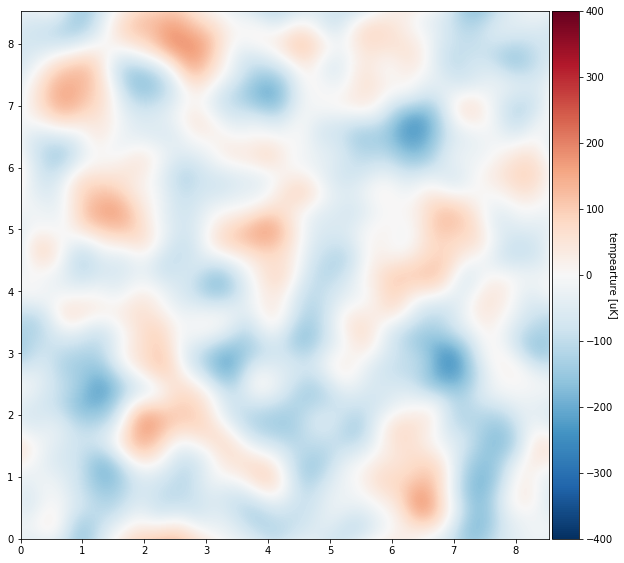

In [352]:
CMB_T_convolved = convolve(30,cmb)
plot_map(CMB_T_convolved,10,10)
plt.savefig('30 arcmin')

<Figure size 432x288 with 0 Axes>

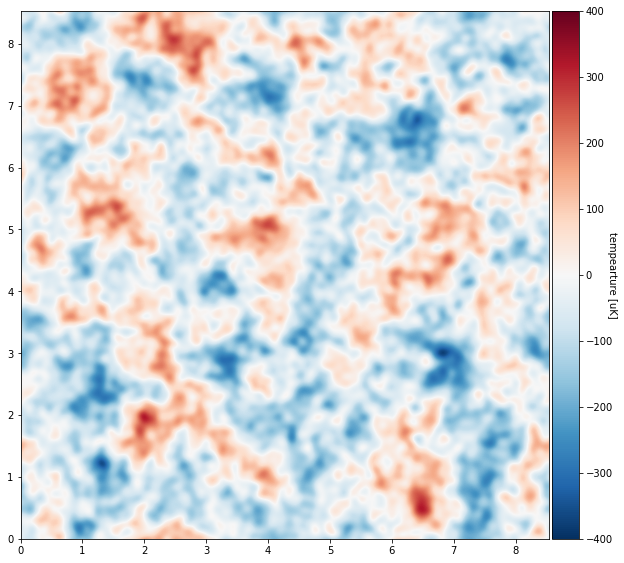

In [353]:
plt.clf()
CMB_T_convolved = convolve(3,cmb)
plot_map(CMB_T_convolved,10,10)
plt.savefig('3 arcmin')

<Figure size 432x288 with 0 Axes>

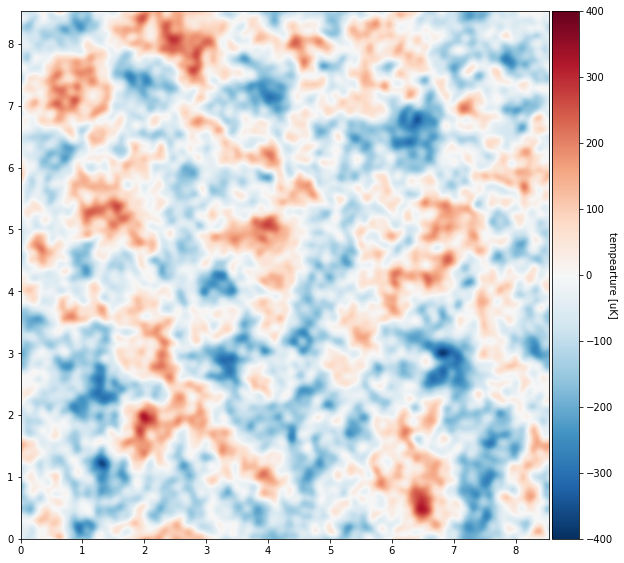

In [361]:
plt.clf()
CMB_T_convolved = convolve(1,cmb)
plot_map(CMB_T_convolved,10,10)
plt.savefig('1 arcmin')

<Figure size 432x288 with 0 Axes>

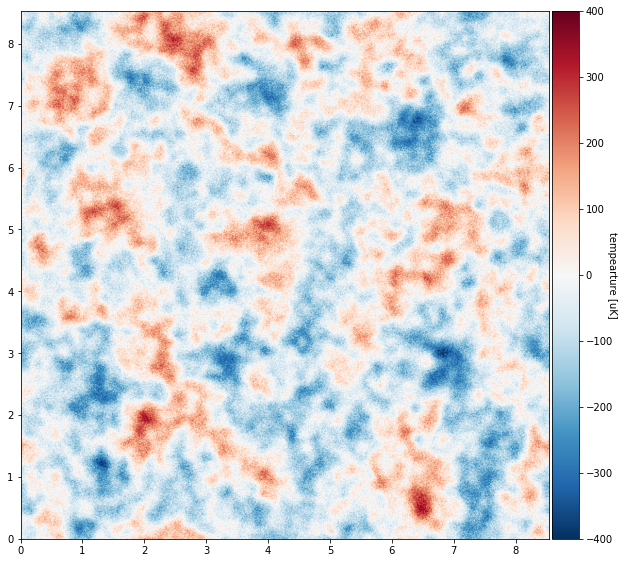

In [363]:
white_noise_level = 30
def make_noise_map(npix,pix_size,white_noise_level):
    white_noise = np.random.normal(0,1,(npix,npix)) * white_noise_level/pix_size
    noise_map = np.real(white_noise)
    return(noise_map)

## make an instrument noise map
Noise = make_noise_map(npix,pix_size,white_noise_level)
total = CMB_T_convolved + Noise

plt.clf()
plot_map(total,10,10)
plt.savefig('Noise 30')

In [267]:
npix = 2**10

<Figure size 432x288 with 0 Axes>

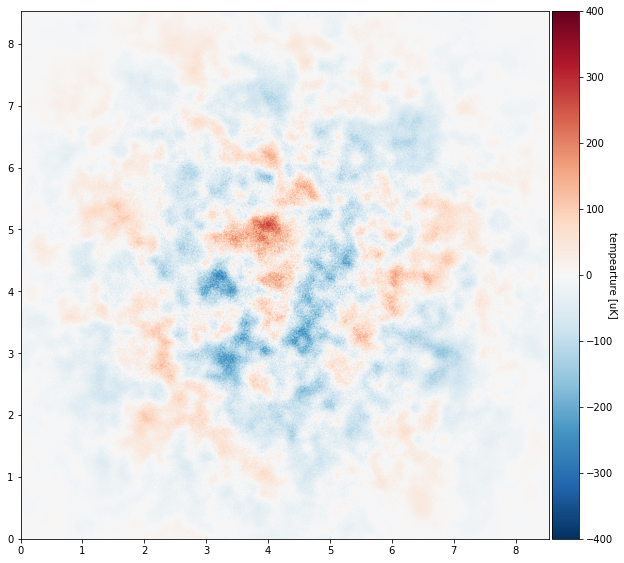

In [364]:
def gaussian_window(npix):
    "makes a gaussian window for apodizing to avoid edges effects in the 2d FFT" 
    # make a 2d coordinate system
    ones = np.ones(npix)
    inds = np.linspace(-0.5, 0.5, npix)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
  
    # make a window map
    sigma = 0.25
    window_map = np.exp(-(X**2)/(2*sigma**2)) * np.exp(-(Y**2)/(2*sigma**2))
    # return the window map
    return(window_map)
  
    
window = gaussian_window(npix)
    
appodized_map = window * total

plt.clf()
plot_map(appodized_map,10,10)
plt.savefig('Gaussian window')

### FFT to recover naive power spectrum from map

### New MCMC to calibrate noise/beam/filtering terms to correct map data and estimate errors

Should result in new unbiased power spectrum obtained from FFT of map

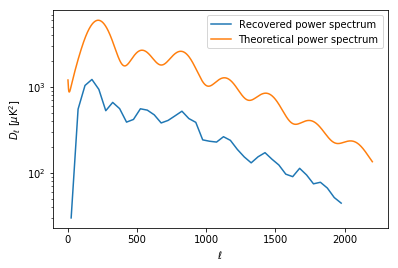

In [309]:
#### parameters for setting up the spectrum
delta_ell = 50.
ell_max = 2000.

def calculate_2d_spectrum(Map1,Map2,delta_ell,ell_max,pix_size,npix):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(npix)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)

## make a power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(appodized_map, appodized_map, delta_ell,ell_max,pix_size,npix)
#print binned_ell
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi, label="Recovered power spectrum")
plt.semilogy(standard[0],standard[1], label="Theoretical power spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.savefig('Naive power spectrum')
plt.show()


In [310]:
N_iterations = 16

def average_N_spectra(spectra,N_spectra,N_ells):
    avgSpectra = np.zeros(N_ells)
    rmsSpectra = np.zeros(N_ells)
    
    # calcuate the average spectrum
    i = 0
    while (i < N_spectra):
        avgSpectra = avgSpectra + spectra[i,:]
        i = i + 1
    avgSpectra = avgSpectra/(1. * N_spectra)
    
    #calculate the rms of the spectrum
    i =0
    while (i < N_spectra):
        rmsSpectra = rmsSpectra +  (spectra[i,:] - avgSpectra)**2
        i = i + 1
    rmsSpectra = np.sqrt(rmsSpectra/(1. * N_spectra))
    
    return(avgSpectra,rmsSpectra)




 signal only sims, iterations complete: 16 of 16

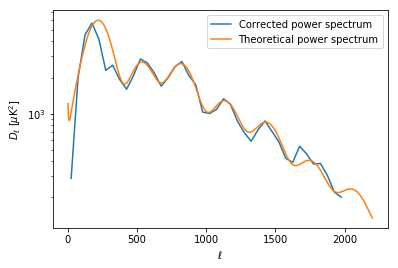

In [312]:
signal_only  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    CMB_T = generate_map(npix,pix_size,standard[0],standard[1])
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(CMB_T*window,CMB_T*window,delta_ell,ell_max,pix_size,npix)
    signal_only[i,:] = binned_spectrum_cur
    sys.stdout.write("\r signal only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

sig_only_mean_spectrum, rms_not_needed = average_N_spectra(signal_only,N_iterations,int(ell_max/delta_ell))
    
sub_sampled_CLs = standard[1][binned_ell] * 2. * np.pi / (binned_ell * (binned_ell+1.))

Multiplicative_Bias_est =  sub_sampled_CLs / sig_only_mean_spectrum
   
## make some plots
plt.clf()
plt.semilogy(binned_ell,(binned_spectrum)*Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,label= "Corrected power spectrum")
plt.semilogy(standard[0],standard[1], label="Theoretical power spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.savefig('Corrected power spectrum')
plt.show()




### Show visualizations for multiple models of the universe's cosmological parameters

Can we visually see the differences in the CMB maps of different models of the universe (lambdaCDM vs "weird" universes)? 
Yes, they clearly look different. How do we quantify this? 2d FFT --> plot power spectrum
This tells us what size bins are significant (i.e. do small bins or big bins (multipole moment) have greater amplitudes (power)?)
The resulting power spectra should look different too


From analyzing and calculating the power spectra of these universes from their observed maps, can we fit them to theory (so lambdaCDM map created + no dark + curved + actually ACT map) This is how we know we must live in a lambda CDM universe

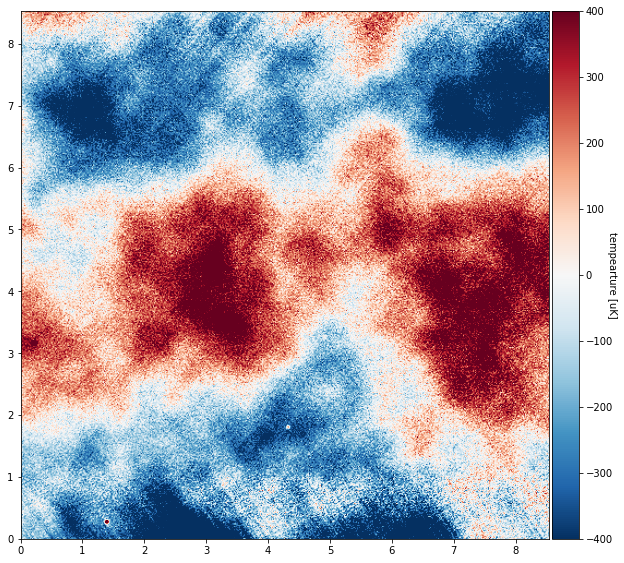

In [367]:
map = fits.getdata('ACT_Season3_148_GHz_submap.fits')
header = fits.getheader('ACT_Season3_148_GHz_submap.fits')

Ny= header['NAXIS2']
N=int(Ny) # take only one dimension
map_patch = map[0:int(N), 0:int(N)] #trimming the map down to size
plot_map(map_patch,10,10)
plt.savefig('ACT real')


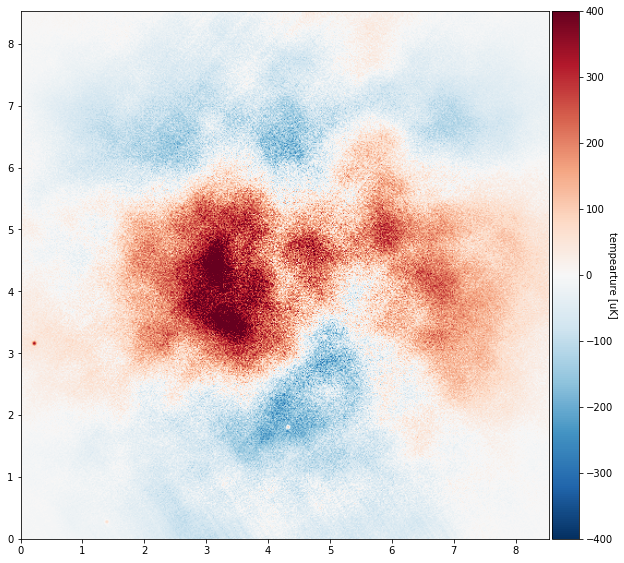

In [368]:
window = (gaussian_window(N))
real_map = window * map_patch
plot_map(real_map,10,10)
plt.savefig('ACT apodized')

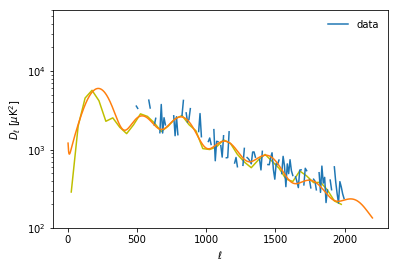

In [334]:
delta_ell = 10# cs.delta_ell
ell_max = 2000

        
binned_ell_theory, binned_spectrum_theory = \
    calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,npix)
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(real_map,real_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell,(binned_spectrum)*Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,color='y')

plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(standard[0],standard[1])
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()